## Autoencoders Lab
#### visualizing HapMap phase 3 populations

**This is a solution template. Every chunk of code requiring your input will begin with the # TASK comment and all places where you should fill-in with your code are marked by ellipsis (...).**

### Stage 0 &mdash; getting the data

First, we will download the data from the linked Dropbox account. The code is hidden as it is not super important here. Double-click below if you are curious to see it!



In [ ]:
import tensorflow as tf

# GPU list
gpus = tf.config.list_physical_devices('GPU')

# Select GPU 1
tf.config.set_visible_devices(gpus[1], 'GPU')

In [ ]:
#@title Load raw data. Double click to see the code. { display-mode: "form" }

!wget https://www.dropbox.com/s/g7862q1l4ls9z3x/autosomal_5k_matrix.csv
!wget https://www.dropbox.com/s/3lv0062dw20qdqg/autosomal_5k_phenos.csv
!wget https://www.dropbox.com/s/6nzrusxkm536a5j/autosomal_5k_kinship.csv

Now, we will load the data and make sure they look as expected. Note, the genotypes per individual (row) are encoded as the count of minor alleles and thus can take values `gt = {0, 1, 2}`.

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

data = pd.read_csv("autosomal_5k_matrix.csv", header=0, index_col=0)
pheno = pd.read_csv("autosomal_5k_phenos.csv", header=0, index_col=0)

print(data)
print(pheno)


         rs416967  rs17013842  rs13052452  rs11049986  rs10994341  rs1504289  \
NA19919         2           1           0           1           1          0   
NA19916         1           0           0           1           1          0   
NA19835         0           0           1           1           0          1   
NA20282         1           1           0           1           0          0   
NA19703         0           0           0           0           1          1   
...           ...         ...         ...         ...         ...        ...   
NA19119         1           0           1           0           1          1   
NA18860         1           0           0           1           1          0   
NA19207         2           0           0           0           1          0   
NA19103         1           0           1           0           0          0   
NA19099         0           0           1           1           0          1   

         rs882529  rs3885937  rs537330 

Now, we will create a dictionary and re-name our populations so that the names are a bit more informative:

In [4]:
pop_dict = {'ASW':'African ancestry in SW USA',
            'CEU':'Utah residents with N and W European ancestry',
            'CHB':'Han Chinese in Beijing China',
            'CHD':'Chinese in Metropolitan Denver Colorado',
            'GIH':'Gujarati Indians in Houston Texas',
            'JPT':'Japanese in Tokyo Japan',
            'LWK':'Luhya in Webuye Kenya',
            'MEX':'Mexican ancestry in Los Angeles California',
            'MKK':'Maasai in Kinyawa Kenya',
            'TSI':'Toscans in Italy',
            'YRI':'Yoruba in Ibadan Nigeria'}
pheno2 = pheno.replace({"population": pop_dict})
pheno2

,id,sex,FID,dad,mom,pheno,population
NA19919,NA19919,1,2427,NA19908,NA19909,0,African ancestry in SW USA
NA19916,NA19916,1,2431,0,0,0,African ancestry in SW USA
NA19835,NA19835,0,2424,0,0,0,African ancestry in SW USA
NA20282,NA20282,0,2469,0,0,0,African ancestry in SW USA
NA19703,NA19703,1,2368,0,0,0,African ancestry in SW USA
...,...,...,...,...,...,...,...
NA19119,NA19119,1,Y060,0,0,0,Yoruba in Ibadan Nigeria
NA18860,NA18860,1,Y012,NA18859,NA18858,0,Yoruba in Ibadan Nigeria
NA19207,NA19207,1,Y051,0,0,0,Yoruba in Ibadan Nigeria
NA19103,NA19103,1,Y042,NA19101,NA19102,0,Yoruba in Ibadan Nigeria


In [7]:
# TASK Scaling
# We need to scale our counts data so that it is bound between 0 and 1.

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
geno_data = pd.DataFrame(scaler.fit_transform(data), index=data.index, columns=data.columns)
geno_data

,rs416967,rs17013842,rs13052452,rs11049986,rs10994341,rs1504289,rs882529,rs3885937,rs537330,rs9372090,...,rs1558766,rs7818288,rs1051685,rs11223492,rs789492,rs6557516,rs7313246,rs317892,rs11937009,rs2806497
NA19919,1.0,0.5,0.0,0.5,0.5,0.0,0.0,0.5,0.5,0.5,...,0.0,0.5,0.0,0.0,0.5,0.0,0.5,0.5,0.5,0.0
NA19916,0.5,0.0,0.0,0.5,0.5,0.0,0.5,0.5,1.0,0.5,...,0.0,0.0,0.0,0.0,0.0,1.0,0.5,0.5,0.5,0.0
NA19835,0.0,0.0,0.5,0.5,0.0,0.5,0.0,1.0,1.0,0.5,...,0.0,0.5,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
NA20282,0.5,0.5,0.0,0.5,0.0,0.0,0.0,0.0,0.5,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.5,1.0,0.0,0.0
NA19703,0.0,0.0,0.0,0.0,0.5,0.5,0.0,0.0,0.0,1.0,...,0.0,0.5,0.5,0.0,0.5,1.0,0.5,0.5,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NA19119,0.5,0.0,0.5,0.0,0.5,0.5,0.5,0.5,0.5,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0
NA18860,0.5,0.0,0.0,0.5,0.5,0.0,0.0,0.5,1.0,0.5,...,0.5,0.5,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.5
NA19207,1.0,0.0,0.0,0.0,0.5,0.0,0.5,0.5,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.5,0.5,0.0
NA19103,0.5,0.0,0.5,0.0,0.0,0.0,0.5,0.5,1.0,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.5,1.0,0.0


In [8]:
# TASK Randomly split into the training and the validation set, so that 80 per-cent of individuals ends up in the training set.

train = geno_data.sample(frac=0.8, random_state=42)  # frac=0.8 → 80% training
test = geno_data.drop(train.index)
train.reset_index()
test.reset_index()

# TASK Print some info about the resulting split
print("Total number of individuals:", ...)
print("\t - training set:", ...)
print("\t - test set:", ...)

Total number of individuals: Ellipsis
	 - training set: Ellipsis
	 - test set: Ellipsis


In [9]:
# TASK Specify the autoencoder model

train_tensor = train.to_numpy()
print(type(train_tensor))

# TASK Hyperparameters
# use ReLu activations, ADAM optimizer and
# mean squared error as the loss function
hp_loss_fn = 'mse'
hp_act_fn = 'relu'
hp_optimizer = 'adam'
hp_metrics = ['mse','mae','mape']

input_data = keras.Input(shape = (train_tensor.shape[1],))

# TASK Define architecture of the encoder:
# the second layer should be a batch normalization

def Encoder(input):
  # Encoder
  layer1 = layers.Dense(units = 1500, activation = hp_act_fn, name='layer1')(input)
  layer2 = layers.BatchNormalization(name='layer2')(layer1)  # batch norm
  layer3 = layers.Dropout(rate = 0.05, name='layer3')(layer2)
  layer4 = layers.Dense(units = 250, activation = hp_act_fn, name='layer4')(layer3)
  layer5 = layers.Dropout(rate = 0.025, name='layer5')(layer4)
  layer6 = layers.Dense(units = 25, activation = hp_act_fn, name='layer6')(layer5)
  bottleneck = layers.Dense(units = 2, name='layer_bottleneck')(layer6)
  return(bottleneck)

# TASK Look at the encoder, complete the decoder function

def Decoder(bottleneck):
  # Decoder
  layer7 = layers.Dense(units = 25, activation = hp_act_fn)(bottleneck)
  layer8 = layers.Dropout(rate=0.025, name='layer8')(layer7)
  layer9 = layers.Dense(units=250, activation=hp_act_fn, name='layer9')(layer8)
  layer10 = layers.Dropout(rate=0.05, name='layer10')(layer9)
  layer11 = layers.Dense(units=1500, activation=hp_act_fn, name='layer11')(layer10)
  layer12 = layers.Dense(units = train_tensor.shape[1], activation = 'sigmoid')(layer11)
  return(layer12)

def Autoencoder(input):
  enc = Encoder(input)
  autoenc = Decoder(enc)
  return(autoenc)

autoencoder_model = keras.Model(inputs = input_data, outputs = Autoencoder(input_data))
autoencoder_model.compile(
  loss = hp_loss_fn,
  optimizer = hp_optimizer,
  metrics = hp_metrics
)

# TASK Visualise the created architecture and summarise its parameters
autoencoder_model.summary()

<class 'numpy.ndarray'>


I0000 00:00:1764174740.211517 1736296 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46761 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:b3:00.0, compute capability: 8.6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 5000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer1 (Dense)                  │ (None, 1500)           │     7,501,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer2 (BatchNormalization)     │ (None, 1500)           │         6,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer3 (Dropout)                │ (None, 1500)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer4 (Dense)                  │ (None, 250)            │       375,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer5 (Dropout)                │ (None, 250)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer6 (Dense)                  │ (None, 25)             │         6,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_bottleneck (Dense)        │ (None, 2)              │            52 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │            75 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer8 (Dropout)                │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer9 (Dense)                  │ (None, 250)            │         6,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer10 (Dropout)               │ (None, 250)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer11 (Dense)                 │ (None, 1500)           │       376,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5000)           │     7,505,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,777,152 (60.19 MB)

 Trainable params: 15,774,152 (60.17 MB)

 Non-trainable params: 3,000 (11.72 KB)

In [ ]:
# TASK Set hyperparameters for model fitting
# Begin by training for 30 epochs, with mini-batch of 256 and validation set
# having 20 per-cent of examples

hp_epochs = 30          
hp_batch_size = 256     # mini-batch size
hp_val_split = 0.2      # 20% of training data for validation

autoencoder = autoencoder_model.fit(x = train_tensor,
                      y = train_tensor,
                      epochs = hp_epochs,
                      batch_size = hp_batch_size,
                      shuffle = True,
                      validation_split = hp_val_split,
                      )

Now, let us look at the training process:

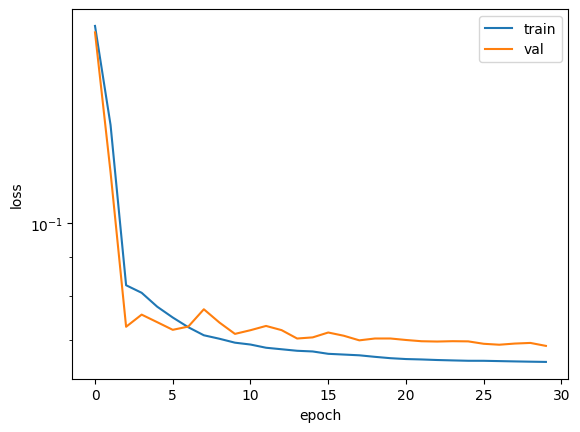

In [20]:
plt.figure()
plt.plot(autoencoder.history['loss'])
plt.plot(autoencoder.history['val_loss'])
plt.ylabel('loss')
plt.yscale("log")
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

Now, that the model is trained, we can save the weights and use them to build an encoder. Note that weights are saved for the entire autoencoder, so we need to use `skip_mismatch = True` along with `by_name = True` to initialize weights in our encoder.

In [21]:
autoencoder_model.save_weights('autoencoder_weights.weights.h5',
                               overwrite = True)

encoder_model = keras.Model(inputs = input_data, outputs = Encoder(input_data))
encoder_model.load_weights('autoencoder_weights.weights.h5',
                           skip_mismatch = True)
encoder_model.compile(
  loss = hp_loss_fn,
  optimizer = hp_optimizer,
  metrics = hp_metrics,
)


Let us embed our genotyping data using the encoder we have just constructed.
We can also visualise the embedding.

2025-11-26 17:39:02.770867: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_40', 96 bytes spill stores, 96 bytes spill loads



37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
[[ 8.665658  11.56378  ]
 [ 7.1225038 10.474253 ]
 [ 6.940741  12.360845 ]
 ...
 [ 8.107979  11.59588  ]
 [ 8.692365  11.984523 ]
 [ 8.629196  11.112962 ]]


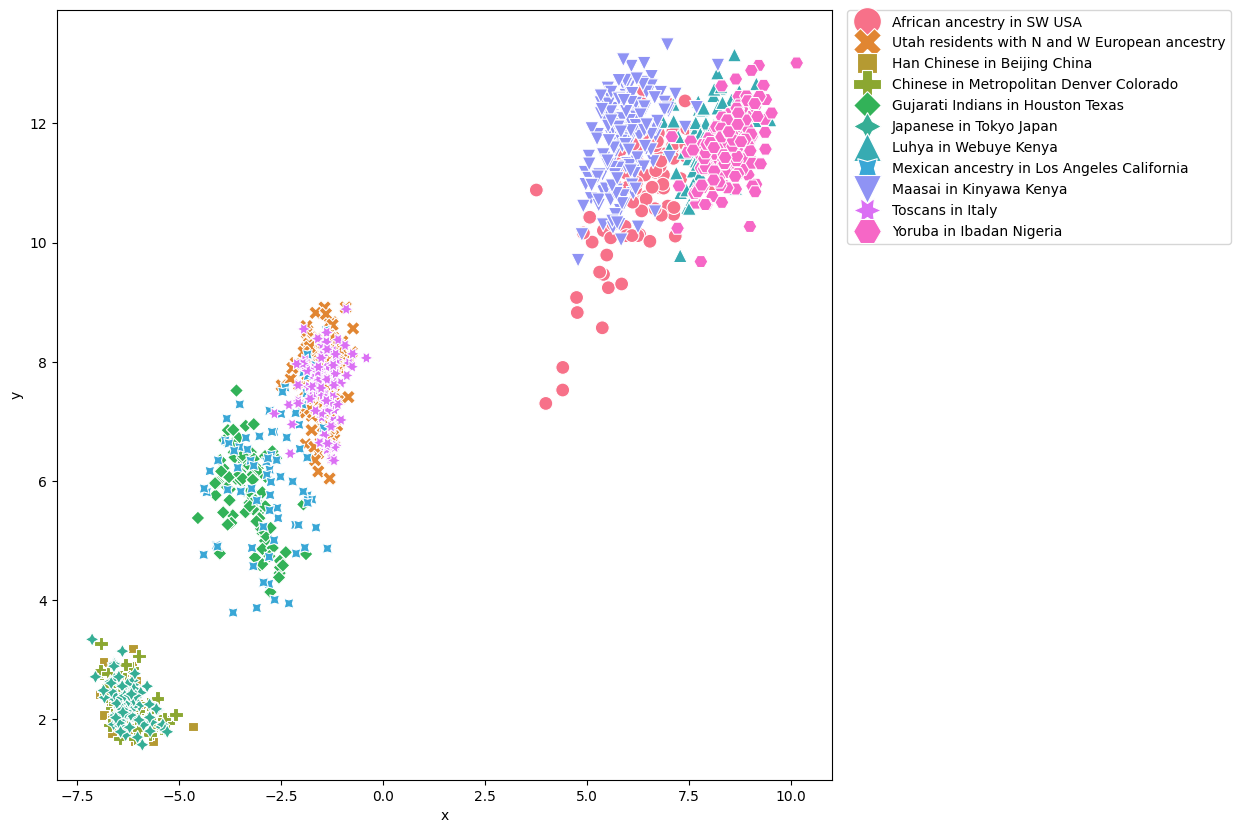

In [22]:
embeded_points = encoder_model.predict(geno_data.to_numpy())
print(embeded_points)

x = embeded_points[:,0]
y = embeded_points[:,1]
pop = pheno2['population']
data = {'x':x, 'y':y, 'pop':pop}
plt.figure(figsize = (10,10))
sns.scatterplot(x='x', y='y', data=data, hue='pop', style='pop', s=100)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, markerscale=2)
plt.show()

Now, we will compare the result with:
* MDS on the kinship matrix
* PCA perfored directly on raw genotypes


In [23]:
kinship = pd.read_csv("autosomal_5k_kinship.csv", header=0, index_col=0)


In [28]:
from sklearn.manifold import MDS
embedding = MDS(n_components=2)
mds_embedding = embedding.fit_transform(kinship)


/home/damian/miniforge3/envs/adl/lib/python3.10/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(
/home/damian/miniforge3/envs/adl/lib/python3.10/site-packages/sklearn/manifold/_mds.py:687: UserWarning: The MDS API has changed. ``fit`` now constructs a dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


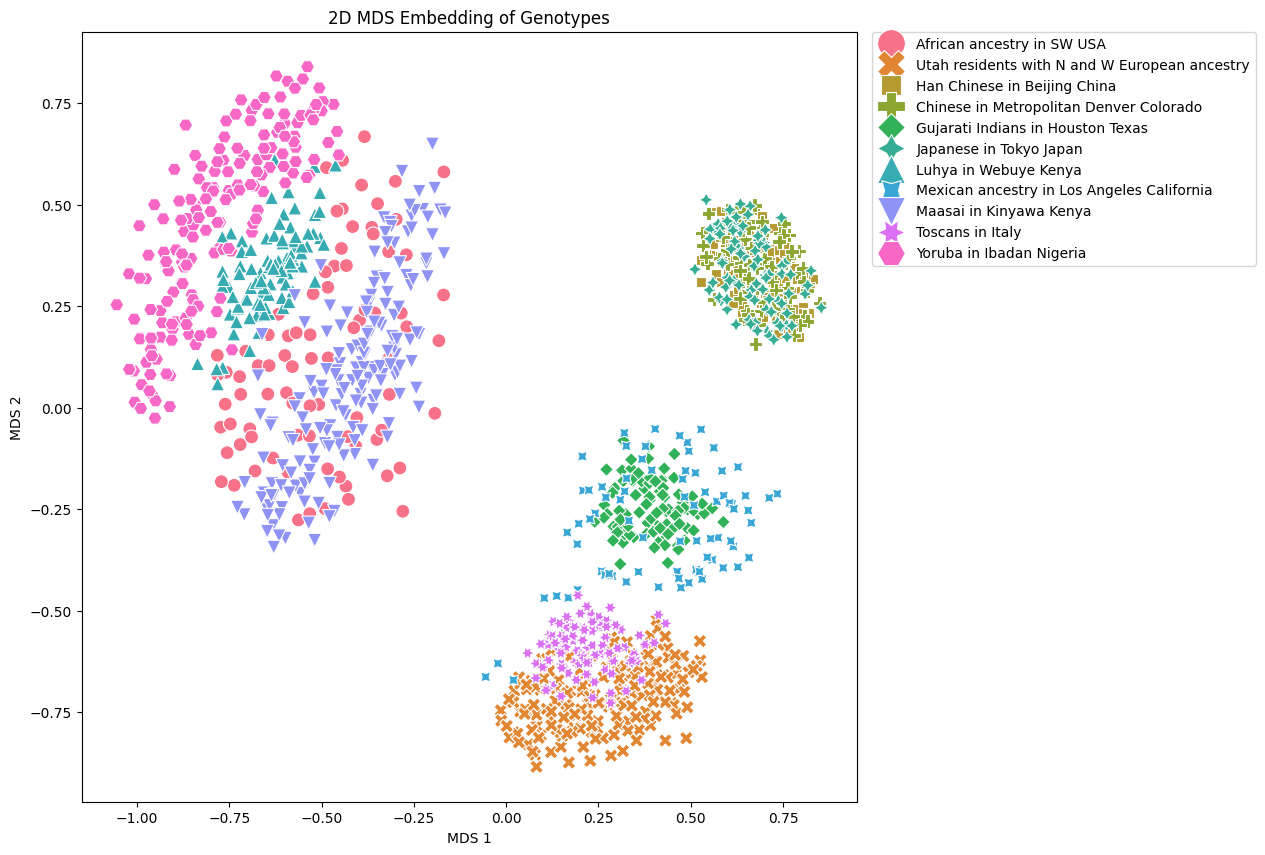

In [29]:
# TASK Plot MDS embedding in a way similar to plotting autoencoder embeddings
x = mds_embedding[:,0]
y = mds_embedding[:,1]
data = {'x':x, 'y':y, 'pop':pop}

plot_df = pd.DataFrame({'x': x, 'y': y, 'pop': pop})

plt.figure(figsize = (10,10))
sns.scatterplot(x='x', y='y', data=plot_df, hue='pop', style='pop', s=100)
plt.xlabel('MDS 1')
plt.ylabel('MDS 2')
plt.title('2D MDS Embedding of Genotypes')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, markerscale=2)
plt.show()

Finally, we will perform PCA on raw genotypes:

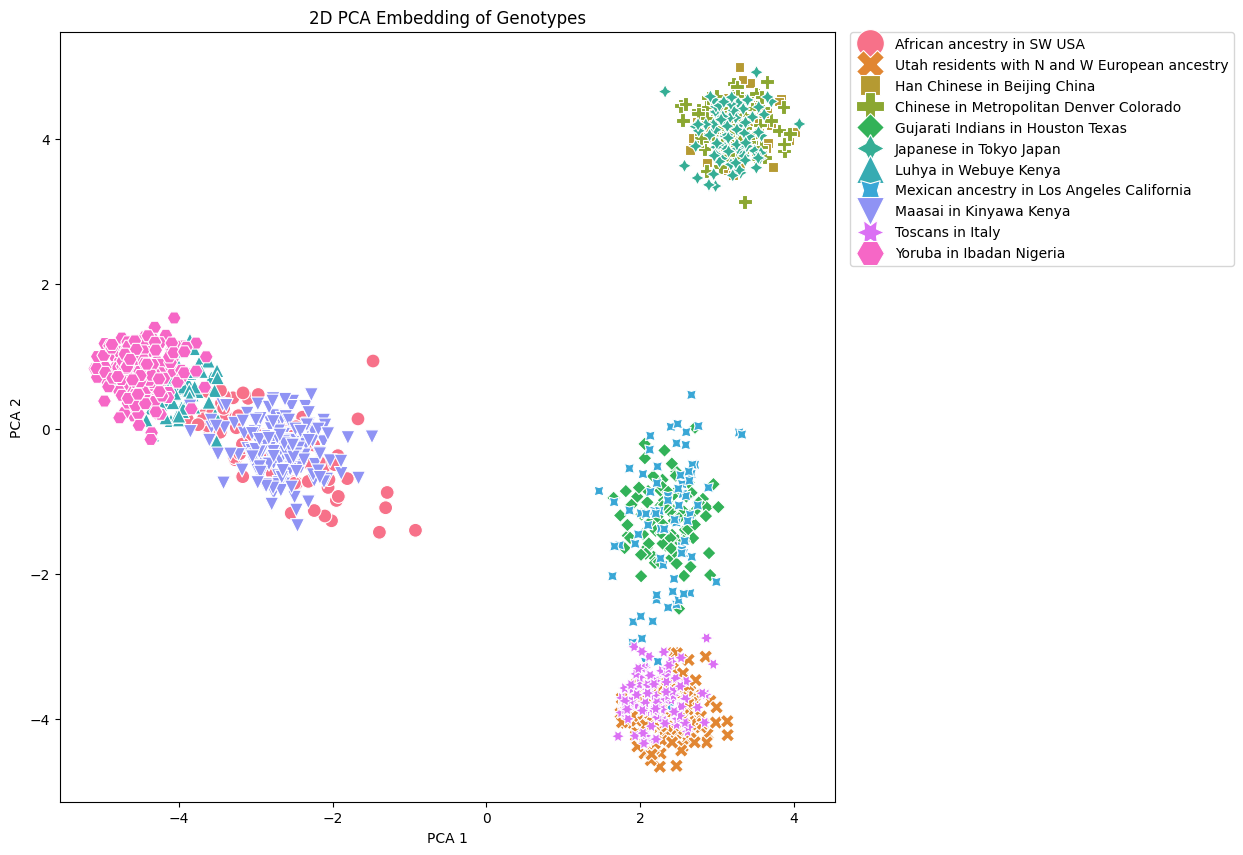

In [30]:
# TASK perform PCA with 2 components on raw genotypes (use geno_data as input but remember it has been scaled)
# Visualise the result.
from sklearn.decomposition import PCA
embedding = PCA(n_components=2)
pca_embedding = embedding.fit_transform(geno_data.to_numpy()) 

x = pca_embedding[:,0]
y = pca_embedding[:,1]
pop = pheno2['population']

plot_df = pd.DataFrame({'x': x, 'y': y, 'pop': pop})

plt.figure(figsize=(10,10))
sns.scatterplot(x='x', y='y', data=plot_df, hue='pop', style='pop', s=100)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('2D PCA Embedding of Genotypes')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, markerscale=2)
plt.show()